In [2]:
import os
import numpy as np
import pandas as pd
from nilearn import masking, image
from scipy.stats import ttest_1samp, pearsonr,ttest_ind
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style('white')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

<ipython-input-141-d3b7571c5f67>:15: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='ifold', y="statistic", data=data,alpha=0.15,


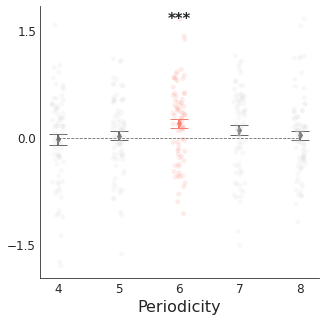

In [141]:
sns.set_style("white")
data = pd.read_csv(r'/mnt/workdir/DCM/Result/Specificity_to_6/nilearn_cv/sub_stats-z_roi-ec_trial-even.csv')
# high performance filter
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
hp_info = participants_data.query(f'(game1_fmri>=0.5)and(game1_acc>0.8)')  # look out
hp_sub = hp_info['Participant_ID'].to_list()
data = data.loc[data['sub_id'].isin(hp_sub)]

fig, ax = plt.subplots(figsize=(5, 5))
#sns.boxplot(x='ifold', y="statistic", data=data, width=.5,
#            palette=["lightgray", "lightgray", "steelblue", "lightgray", "lightgray"],
#            boxprops={'edgecolor':'None','facecolor':'None'},showfliers=False,
#            )
sns.stripplot(x='ifold', y="statistic", data=data,alpha=0.15,
              palette=["lightgray", "lightgray", 'salmon', "lightgray", "lightgray"])
ax.tick_params(axis='both', length=0)
x = [0,1,2,3,4]
y = [0]*len(x)
plt.plot(x, y, linestyle='--', color='black',linewidth=0.8,alpha=0.6)

# Calculate SEM for each group
sem = data.groupby('ifold')['statistic'].sem().values

# Plot error bars
palette=["dimgray", "dimgray", 'salmon', "dimgray", "dimgray"]
for i, group in enumerate(data.groupby('ifold')):
    ax.errorbar(i, group[1]['statistic'].mean(), yerr=sem[i], fmt='none', color=palette[i], capsize=9,linewidth=2)
    plt.plot(i,group[1]['statistic'].mean(), marker='d', markersize=4.5,color=palette[i])

plt.xticks([0,1,2,3,4],[4,5,6,7,8],size=12)
plt.yticks([-1.5,0,1.5],size=12)
plt.xlabel('Periodicity',size=16)
plt.ylabel('')
# remove the box lines of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Add asterisks on top of each bar
vmean = np.max(data['ifold']=='6fold')
ax.text(2, vmean+0.55, '***',ha='center', va='bottom',weight='bold',size=15)

sub_num = len(set(data['sub_id']))
#plt.title("HP participants(num={})".format(sub_num),size=16)
plt.savefig(r'/mnt/workdir/DCM/Result/Specificity_to_6/nilearn_cv/Specificity_to_6fold_new.svg',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

In [16]:
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('(game1_fmri>=0.5)and(game1_acc>0.8)')
subjects = data['Participant_ID'].to_list()
num = len(subjects)
# set camp
cmap_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/distance_spct/Setall/6fold/{}/zmap/M2_corrxdistance_zmap.nii.gz'
sub_cmap_paths = [cmap_template.format(sub_id) for sub_id in subjects]

# set roi
roi1 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/lHC_MNI152NL.nii.gz')
roi2 = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/hippocampus/rHC_MNI152NL.nii.gz')
hc = image.math_img('np.logical_or(img1,img2)', img1=roi1, img2=roi2)
ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
#ec = image.load_img(r'/mnt/data/DCM/result_backup/2023.4.17/game1/hexagon_spct/EC_thr3.1.nii.gz')
ec = image.binarize_img(ec,10)

# extract mean activity of ROI for each subjects
subs_hc_mact = np.mean(masking.apply_mask(sub_cmap_paths, hc), axis=1)
subs_ec_mact = np.mean(masking.apply_mask(sub_cmap_paths, ec), axis=1)

# mean
t_statistic, p_value = ttest_1samp(subs_hc_mact, 0)
print("HC's t:", t_statistic)
print("HC's p:", p_value)

t_statistic, p_value = ttest_1samp(subs_ec_mact, 0)
print("EC's t:", t_statistic)
print("EC's p:", p_value)

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


HC's t: 3.7553077171530407
HC's p: 0.0003424832133881061
EC's t: 2.1513875476174364
EC's p: 0.034709515863900385


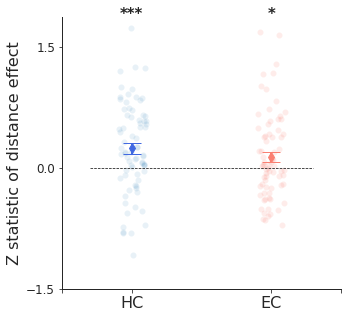

In [17]:
fig, ax = plt.subplots(figsize=(5,5))

# Plot HC result
# plot scatter
xjitter = np.random.uniform(-0.1, 0.1,size=len(subs_hc_mact)) - 0.5
sns.scatterplot(x=xjitter,y=subs_hc_mact,alpha=0.1)
# plot bar
hc_bar = sns.barplot(x=[-0.5], y=[subs_hc_mact.mean()], alpha=0,color='None', capsize=0.1, errcolor='blue', errwidth=1.5, error_kw={'ecolor':'blue'},)
hc_bar.errorbar(x=[-0.5], y=[subs_hc_mact.mean()], yerr=[np.std(subs_hc_mact, ddof=1) / np.sqrt(len(subs_hc_mact))], fmt='none', ecolor='royalblue', capsize=9,linewidth=2)
# Add a point to represent the mean of subs_mean_activity
mean_val = subs_hc_mact.mean()
plt.plot(-0.5,mean_val*1.02, marker='d', markersize=7,color='royalblue',zorder=100)
# Add asterisks on top of each bar
vmean = np.mean(subs_hc_mact)
ax.text(-0.5, vmean+1.57, '***', ha='center', va='bottom',weight='bold',size=15)

# Plot EC result
# plot scatter
xjitter = np.random.uniform(-0.1, 0.1, size=len(subs_ec_mact)) + 0.5
sns.scatterplot(x=xjitter,y=subs_ec_mact,alpha=0.15,color='salmon')
# plot bar
ec_bar = sns.barplot(x=[0.5], y=[subs_ec_mact.mean()], alpha=0,color='salmon', capsize=0.1, errcolor='None', errwidth=1.5, error_kw={'ecolor':'None'})
ec_bar.errorbar(x=[0.5], y=[subs_ec_mact.mean()], yerr=[np.std(subs_ec_mact, ddof=1) / np.sqrt(len(subs_ec_mact))], fmt='none', ecolor='salmon', capsize=9,linewidth=2)
# Add a point to represent the mean of subs_mean_activity
mean_val = subs_ec_mact.mean()
plt.plot(0.5,mean_val*1.02, marker='d', markersize=7,color='salmon')
# Add asterisks on top of each bar
vmean = np.mean(subs_hc_mact)
ax.text(0.5, vmean+1.57, '*',ha='center', va='bottom',weight='bold',size=15)

# Add a horizontal line
ax.hlines(y=0, xmin=-0.8, xmax=0.8, colors='black', linestyles='--', linewidth=0.7)
# Set the y-axis label and remove the top and right spines
ax.set_ylabel('Z statistic of distance effect',size=16)
sns.despine(top=True, right=True)

# Modify the bottom and left spines
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)

# Set custom ticks for the x-axis and y-axis
plt.yticks([-1.5,0,1.5],size=12)
plt.xticks([-1, -0.5, 0.5 ,1],['','HC','EC',''],size=16)

# Add tick lines to the bottom and left spines
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
#plt.savefig(r'/mnt/workdir/DCM/Result/MRI/Game1/distance/distance_sub-hp.svg',bbox_inches='tight',pad_inches=0,dpi=300,transparent=True)
plt.show()

In [132]:
# plot align vs misalign

# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('(game1_fmri>=0.5)and(game1_acc>0.8)')
subjects = data['Participant_ID'].to_list()
num = len(subjects)
# set camp
algin_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_align_spct/Setall/6fold/{}/zmap/m2_alignPhi_even_zmap.nii.gz'
misalgin_template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_align_spct/Setall/6fold/{}/zmap/m2_misalign_even_zmap.nii.gz'
sub_algin_cmaps = [algin_template.format(sub_id) for sub_id in subjects]
sub_misalgin_cmaps = [misalgin_template.format(sub_id) for sub_id in subjects]

# load mask
ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
ec = image.binarize_img(ec,10)

# load data
subs_align_mact = np.mean(masking.apply_mask(sub_algin_cmaps, ec), axis=1)
subs_misalign_mact = np.mean(masking.apply_mask(sub_misalgin_cmaps, ec), axis=1)
# demean for each subjects
mean_mact = np.mean(subs_align_mact+subs_misalign_mact,axis=0)
subs_mact = np.concatenate((subs_align_mact-mean_mact,subs_misalign_mact-mean_mact),axis=0)
subs_align_mact = subs_align_mact-mean_mact
subs_misalign_mact = subs_misalign_mact-mean_mact
align_data = pd.DataFrame({'Activity':subs_mact,'Group':num*['Align']+num*['Misalign']})

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


In [133]:
# mean
t_statistic, p_value = ttest_1samp(subs_align_mact, 0)
print("Align's t:", t_statistic)
print("Align's p:", p_value)

t_statistic, p_value = ttest_1samp(subs_misalign_mact, 0)
print("Misalign's t:", t_statistic)
print("Misalign's p:", p_value)

t_statistic, p_value = ttest_1samp(subs_align_mact-subs_misalign_mact,0)
print("Align vs Misalign's t:", t_statistic)
print("Align vs Misalign's p:", p_value)

Align's t: 16.84165693836668
Align's p: 4.9971528854208325e-27
Misalign's t: -1.506579593271729
Misalign's p: 0.13617560799318795
Align vs Misalign's t: 9.25384014921927
Align vs Misalign's p: 5.524168378512977e-14


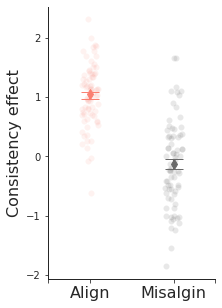

In [142]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(3,5))

# Plot align result
# plot scatter
xjitter = np.random.uniform(-0.1, 0.1,size=len(subs_align_mact)) - 0.5
sns.scatterplot(x=xjitter,y=subs_align_mact,alpha=0.1,color='salmon')
# plot bar
hc_bar = sns.barplot(x=[-0.5], y=[subs_align_mact.mean()], alpha=0,color='None', capsize=0.1, errcolor='blue', errwidth=1.5, error_kw={'ecolor':'blue'},)
hc_bar.errorbar(x=[-0.5], y=[subs_align_mact.mean()], yerr=[np.std(subs_align_mact, ddof=1) / np.sqrt(len(subs_align_mact))], fmt='none', ecolor='salmon', capsize=9,linewidth=2)
# Add a point to represent the mean of subs_mean_activity
mean_val1 = subs_align_mact.mean()
plt.plot(-0.5,mean_val1*1.02, marker='d', markersize=7,color='salmon',zorder=100)

# Plot misalign result
# plot scatter
xjitter = np.random.uniform(-0.1, 0.1, size=len(subs_misalign_mact)) + 0.5
sns.scatterplot(x=xjitter,y=subs_misalign_mact,alpha=0.15,color="dimgray")
# plot bar
ec_bar = sns.barplot(x=[0.5], y=[subs_misalign_mact.mean()], alpha=0,color="dimgray", capsize=0.1, errcolor='None', errwidth=1.5, error_kw={'ecolor':'None'})
ec_bar.errorbar(x=[0.5], y=[subs_misalign_mact.mean()], yerr=[np.std(subs_misalign_mact, ddof=1) / np.sqrt(len(subs_misalign_mact))], fmt='none', ecolor="dimgray", capsize=9,linewidth=2)
# Add a point to represent the mean of subs_mean_activity
mean_val2 = subs_misalign_mact.mean()
plt.plot(0.5,mean_val2*1.02, marker='d', markersize=7,color="dimgray")

# Modify the bottom and left spines
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
# remove the box lines of the axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_ylabel('Consistency effect',size=16)
# Set custom ticks for the x-axis and y-axis
#plt.yticks(,size=12)
plt.xticks([-1, -0.5, 0.5 ,1],['','Align','Misalgin',''],size=16)

# Add tick lines to the bottom and left spines
ax.tick_params(axis='x', which='both', bottom=True, top=False, direction='out')
ax.tick_params(axis='y', which='both', left=True, right=False, direction='out')
plt.savefig(r'/mnt/workdir/DCM/Result/MRI/Game1/Hexagon_CV/cv_6fold_align_misalign.svg',dpi=300,bbox_inches='tight')
plt.show()

In [6]:
# plot align vs misalign 12 bin
# specify subjects
participants_tsv = r'/mnt/workdir/DCM/BIDS/participants.tsv'
participants_data = pd.read_csv(participants_tsv, sep='\t')
data = participants_data.query('(game1_fmri>=0.5)and(game1_acc>0.8)')
subjects = data['Participant_ID'].to_list()
num = len(subjects)

# load mask
ec = image.load_img(r'/mnt/workdir/DCM/Docs/Mask/EC/juelich_EC_MNI152NL_prob.nii.gz')
ec = image.binarize_img(ec,0)
#ec = image.load_img(r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_train_hexagon_spct/EC_thr3.1.nii.gz')
# load data
bin12 = pd.DataFrame()
# set camp
template = r'/mnt/workdir/DCM/BIDS/derivatives/Nilearn/game1/cv_test_align_spct/Setall/6fold/{}/zmap/{}_{}_{}_even_zmap.nii.gz'
for onset in ['m2']:
    for bin in range(1,13,1):
        if bin in range(1,13,2):
            cmaps = [template.format(sub_id,onset,'align',str(bin)) for sub_id in subjects]
        elif bin in range(2,13,2):
            cmaps = [template.format(sub_id,onset,'misalign',str(bin)) for sub_id in subjects]
        subs_mact = np.mean(masking.apply_mask(cmaps, ec), axis=1)
        bin12 = bin12.append(pd.DataFrame({'Activity':subs_mact,'Direction of mental navigation':bin,
                                           'hue':'Align' if bin in range(1,13,2) else 'Misalign','sub_id':subjects,
                                           'onset':onset}))

/home/dell/Software/anaconda3/lib/python3.8/site-packages/nilearn/image/image.py:1041: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(niimg, result, niimg.affine)


<AxesSubplot: xlabel='Direction of mental navigation', ylabel='zscore'>

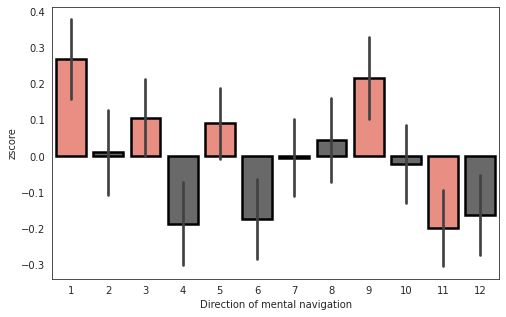

In [4]:
# Zscore for acitivity
bin12['zscore'] = bin12.groupby('sub_id')['Activity'].transform(lambda x: (x - x.mean())/x.std())
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=bin12,x='Direction of mental navigation',y='zscore',palette=['salmon','dimgray'],errorbar='se',edgecolor='black',linewidth=2.5)

<AxesSubplot: xlabel='Direction of mental navigation', ylabel='Activity_demean'>

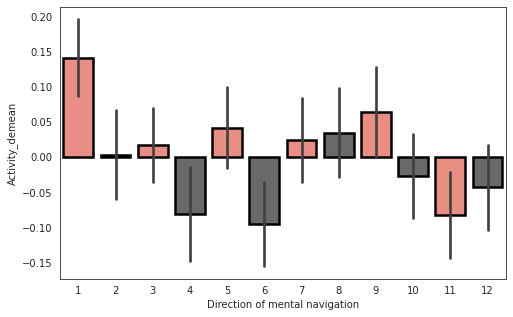

In [7]:
# Demean for acitivity
bin12['Activity_demean'] = bin12['Activity'] - bin12['Activity'].mean()
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(data=bin12,x='Direction of mental navigation',y='Activity_demean',palette=['salmon','dimgray'],errorbar='se',edgecolor='black',linewidth=2.5)